# 集成学习进阶-XGBoost极限梯度提升算法-分类任务

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor # 

objective:

1. 对于回归任务来说:
    - reg:squarederror: 平方损失, 默认值
    - reg:squaredlogerror: 平方对数损失
2. 对于分类任务:
    - binary:logistic: 二分类交叉熵损失,可以使用oredict接口输出概率
    - binary:logitraw: 二分类交叉熵损失, 使用该损失时可以输出执行sigmoid变化之前的值
    - multi: softmax: 多分类交叉熵损失, 使用predict接口可以输出具体的类别
    - multi:sorfprob: 多分类交叉熵, 使用predict接口可以输出每个样本每个类别下面的概率

In [ ]:
from sklearn.datasets import load_breast_cancer, load_digits
import xgboost as xgb
from xgboost import XGBRegressor #

## 二分类任务

### 第一步: 构建数据集"

In [ ]:
X_binary = load_breast_cancer().data
y_binary = load_breast_cancer().target
data_binary = xgb.DMatrix(X_binary, y_binary)

### 第二步: 设置参数

In [ ]:
params = {
    'seed': 1210, 'objective': "binary:logistic"
}

### 第三步: 模型训练

In [ ]:
clf_binary = xgb.train(params, data_binary, num_boost_round=100)

### 第四步: 模型评估

In [ ]:
y_pred_binary = clf_binary.predict(data_binary) # 返回到是概率

In [ ]:
y_binary_predict = (y_pred_binary > 0.5).astype("int") # 再上一步的基础上返回类别

In [ ]:
from rich import print
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as acc # 返回准确率
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss # 当返回是概率时,可以使用交叉熵损失
import seaborn as sns
acc(y_true=y_binary,y_pred=y_binary_predict)
print(f"交叉熵损失为: {log_loss(y_true=y_binary,y_pred=y_binary_predict):.7f}")
print(classification_report(y_true=y_binary, y_pred=y_binary_predict))

In [ ]:
cm = confusion_matrix(y_true=y_binary, y_pred=y_binary_predict)
sns.heatmap(cm,square=True, annot=True, cmap='Blues',fmt='d', linecolor='white',linewidths=2)

### 使用xgboost sklean api完成

In [ ]:
from xgboost import XGBClassifier
clf = XGBClassifier(objective='binary:logistic', seed=1210)  # 实例化模型
clf.fit(X_binary, y_binary)  # 训练模型
y_binary_pred = clf.predict(X_binary)  # 查看预测的分类
y_binary_pred_proba = clf.predict_proba(X_binary) # 查看预测的概率
clf.score(X_binary, y_binary) # 查看评分

## 多分类任务

In [ ]:
X_multi = load_digits().data
y_multi = load_digits().target

In [ ]:
data_multi = xgb.DMatrix(X_multi, y_multi) # 构建数据集
params2 = {'seed': 1210, "objective":"multi:softmax",
          'eval_metric': "mlogloss",
           'num_class': 10
          } #构建参数字典
clf_multi = xgb.train(params2, data_multi, num_boost_round=100)
y_pred_multi = clf_multi.predict(data_multi)

In [ ]:
import  matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Times New Roman'
cm = confusion_matrix(y_true=y_multi, y_pred=y_pred_multi)
plt.figure(figsize=(7,6),dpi=100)
sns.heatmap(cm,square=True, annot=True, cmap='Blues',fmt='d', linecolor='white',linewidths=2)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_multi, y_multi,test_size=0.2, random_state=1210)

In [ ]:
dxtrain= xgb.DMatrix(X_train, y_train) # 构建数据集
dxtest = xgb.DMatrix(X_test, y_test)
params2 = {'seed': 1210, "objective":"multi:softmax",
          'eval_metric': "mlogloss",
           'num_class': 10
          } #构建参数字典
clf_multi = xgb.train(params2, dxtest, num_boost_round=100)
y_pred_multi = clf_multi.predict(dxtest)

In [ ]:
import  matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Times New Roman'
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_multi)
plt.figure(figsize=(7,6),dpi=100)
sns.heatmap(cm,square=True, annot=True, cmap='Blues',fmt='d', linecolor='white',linewidths=2)
plt.show()

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred_multi))

### 多分类问题交叉验证

In [ ]:
params2 = {'seed': 1210, "objective":"multi:softmax",
           'num_class': 10
          } #构建参数字典
result = xgb.cv(params=params2,dtrain=data_multi, num_boost_round=100,
               metrics=('mlogloss','merror'), # 可以填写多个评估指标
               nfold=5,
               seed=1210,
               )
result.head()

### sklean api

In [ ]:
clf = XGBClassifier(objective='multi:softmax',
                    eval_metric='mlogloss',
                    num_class = 10
                   )
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
clf.score(X_test,y_test) # 查看准确率

## XGBoost调参

### 迭代过程中的参数

- eta: learning_rate: 学习率,学习率越大需要的基学习器越少,学习率越小需要的基学习器越多,
- num_boost_round: n_estimators: 基学习器的数量.
- base_socre: base_score: 由于没有第0棵树的存在,因此我们可以使用base_socre来确定第0棵树的分数,默认值是0.5,调不调意义不大,当你的数据足够多,迭代次数足够的大的时候.
- max_delta_step: max_delta_step: 当样本极度不均衡的时候,可以尝试调整这个值,一般1-10左右,单次提升到最大步长

### xgboost的目标函数

$$
\Omega\left(f_k\right)=\gamma T+\frac{1}{2} \lambda \sum_{j=1}^T w_j^2+\alpha \sum_{j=1}^T w_j
$$

其中$\gamma,\lambda\ \alpha$都是可以自由设定的系数,T表示当前第K棵树都上的叶子总数量.$w_j$代表当前树上第j片叶子的权重,

- $\gamma$ (gamma <-> gamma):乘在一棵树的叶子总量T之前,依照叶子总量对目标函数施加惩罚的系数,默认是0,范围$0-\inf$,当叶子总量固定时,$\gamma$越大,结构风险越大,同时,$\gamma$不变时,叶子总量越多,模型复杂度越大,结构风险越大,基于此,调整$\gamma$可以控制过拟合.
- 参数$\lambda$和$\alpha$(lambda <-> reg_lambda)|((alpha <-> reg_alpha)): 正则化系数,依照叶子的权重大小对目标函数施加惩罚的系数,其实就是正则项系数,$\lambda$默认是1,$\alpha$是0,因此xgboost默认使用的L2正则化,通常来说我们不会同时使用两个正则化,但是可以尝试,通过调整$\lambda$和$\alpha$可以空值过拟合,

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
print('Python version:', sys.version)
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Matplotlib version:', matplotlib.__version__)

In [ ]:
data = pd.read_csv('./data/train_encode.csv')
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
data_xgb = xgb.DMatrix(X, y)

In [ ]:
params = {"max_depth":5,'seed': 1210}

result = xgb.cv(params, data_xgb, num_boost_round=100, nfold=5, seed=1210)

In [ ]:
def overfitcheck(result):
    # 返回训练误差和验证误差的最小值,就可以帮助我们识别模型的过拟合程度
    return (result.iloc[-1,2] - result.iloc[-1,0])

In [ ]:
train = []
test = []
gamma = np.arange(0,100,1)
overfit = []

for i in gamma:
    params =  {"max_depth":5,'seed': 1210, 'gamma':float(i)}
    result = xgb.cv(params, data_xgb, num_boost_round=100, nfold=5, seed=1210)
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])

In [ ]:
plt.figure(figsize=(12,7),dpi=1200)
plt.plot(gamma, overfit)
plt.plot(gamma, train) # 训练集误差分数
plt.plot(gamma,test) # 测试集误差分数
plt.xlabel('Gamma Value')
plt.ylabel('Overfit Measure')
plt.title('Effect of Gamma on Overfitting')
plt.show()

### 调整gamma的大小,检测范围

In [ ]:
train = []
test = []
gamma = np.arange(0,1000000,100000)
overfit = []

for i in gamma:
    params =  {"max_depth":5,'seed': 1210, 'gamma':float(i)}
    result = xgb.cv(params, data_xgb, num_boost_round=100, nfold=5, seed=1210)
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])

In [ ]:
plt.figure(figsize=(12,7),dpi=1200)
plt.plot(gamma, overfit)
plt.xlabel('Gamma Value')
plt.ylabel('Overfit Measure')
plt.title('Effect of Gamma on Overfitting')
plt.show()

对于gamma来说,如果树都结构不是很复杂,建议先对gamma的敏感程度进行一个探索,这里gamma参数显然是不敏感的,

当标签值较大,因此预测的标签值也较大,这时候,lambda可能会更敏感一点.

In [ ]:
train = []
test = []
lambda_ = np.arange(0,2,0.1)
overfit = []

for i in lambda_:
    params =  {"max_depth":5,'seed': 1210, 'lambda':float(i)}
    result = xgb.cv(params, data_xgb, num_boost_round=100, nfold=5, seed=1210)
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])

In [ ]:
plt.figure(figsize=(12,7),dpi=1200)
plt.plot(lambda_, overfit)
plt.xlabel('lambda Value')
plt.ylabel('Overfit Measure')
plt.title('Effect of lambda on Overfitting')
plt.show()

In [ ]:
min(overfit)

## 若评估器参数

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
print('Python version:', sys.version)
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Matplotlib version:', matplotlib.__version__)
from rich import print
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as acc # 返回准确率
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss # 当返回是概率时,可以使用交叉熵损失
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor #
data = pd.read_csv('./data/train_encode.csv')
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
data_xgb = xgb.DMatrix(X, y)

- booster:(booster| booster): 使用那种若评估器
    - 'gbtree': 遵循XGBoost规则的CART决策树.
    - 'dart': 抛弃提升树,原理在建立树都过程当中,我们随机抛弃一些树都结果,可以防止过你和,数据量巨大的时候,可以用
    - 'gblinear': 表示使用线性模型,当若评估器是'gblinear'而损失函数是MSE时,表示使用xgboost方法来集成线性回归模型.损失是分类交叉熵损失时,则代表使用xgboost来集成逻辑回归模型.
    
 - rate_drop: 设置0.3表示有30%的树会被抛弃,智能填写0-1之间的浮点树,只有当booster参数设置为dart时才可用
 - one_drop: 每一轮迭代至少有one_drop棵树会被抛弃.
 - skip_drop: 每一轮迭代可以不执行droupout的概率,即使设置booster为dart那么每轮迭代,依旧会以skip_drop的概率不执行Dropout
 
 - sample_type: 抛弃时采用的抽样方法.
     - unifrom:表示均匀的不放回抽样
     - weighted: 表示按没棵树都权重进行不放会抽样.
 - normalize_type: 增加新树是,赋予新树都权重,
     - tree: 表示新生成的树都权重等于所有被抛弃树都权重的均值
     - forest: 表示新生存的树权重等于所有被抛弃树都权重之和.,

In [ ]:
params_dart = {'max_depth':5, "seed":1210, 'eta':0.2,
              'booster':'dart','sample_type':'uniform',
               'normalize_type':'tree',
               'rate_drop': 0.2,
               'skip_drop':0.5,
              }
result_dart = xgb.cv(params_dart,data_xgb, num_boost_round=100, nfold=5, seed=1210)

In [ ]:
def overfitcheck(result):
    # 返回训练误差和验证误差的最小值,就可以帮助我们识别模型的过拟合程度
    return (result.iloc[-1,2] - result.iloc[-1,0])

In [ ]:
overfitcheck(result_dart)

### 空值复杂度-若评估器的剪枝

- max_depth: 树都最大深度,默认是6,在对抗过拟合方向影响不是很大.
- min_child_weight: 简单理解: 任意节点上所允许的样本数量,参数越大模型越不容易过你和,同时学习能力也会变得很弱.
- subsample: 对样本进行抽样的比例,默认是1, 需要注意的是,这里抽样是默认采用不放回抽样,
- sampling_method: 选择抽样方法,
    - unifrom: 均匀抽样,map个样本被周到的概括是一致的
    - gradient_basedm 表示有权重的抽样
    
- colsample_bytree: 特征抽样 发生在建树之前,
- colsample_bylevel: 生长出新一棵树之间有colsample_bylevel抽样,
- colsample__bynode: 每个分支节点前,

其他参数和方法:
    
-  early_stoppiong_rounds(): 如果规定的评估指标不能连续early_stoppiong_round次迭代其他省,那就 提前触发停止
- verbosity: 用于打印训练流程和测试结果都参数,
- scale_pos_weight: 调节样本不均衡的参数, (负样本总量/正样本总量)类似这样的值,正负样本的比例
- nthread: 允许并行度最大线程,默认最大,
- device: 使用GPU进行训练,


## XGBoost的参数空间与超参数优化

gamma: 75万左右有影响,
lambda: 1.5-1.6  (0-2,0.1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
print('Python version:', sys.version)
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Matplotlib version:', matplotlib.__version__)
from rich import print
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as acc # 返回准确率
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss # 当返回是概率时,可以使用交叉熵损失
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor #
data = pd.read_csv('./data/train_encode.csv')
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
data_xgb = xgb.DMatrix(X, y)

Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
Pandas version: 2.2.2
Numpy version: 1.26.4
Matplotlib version: 3.8.4


In [2]:

def overfitcheck(result):
    # 返回训练误差和验证误差的最小值,就可以帮助我们识别模型的过拟合程度
    return (result.iloc[-1,2] - result.iloc[-1,0])

In [3]:
train = []
test = []
option = np.arange(10,200,10)
overfit = []

for i in option:
    params = {'max_depth': 5, 'seed':1210}
    result = xgb.cv(params, data_xgb, num_boost_round=i, nfold=5, seed=1210)
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])

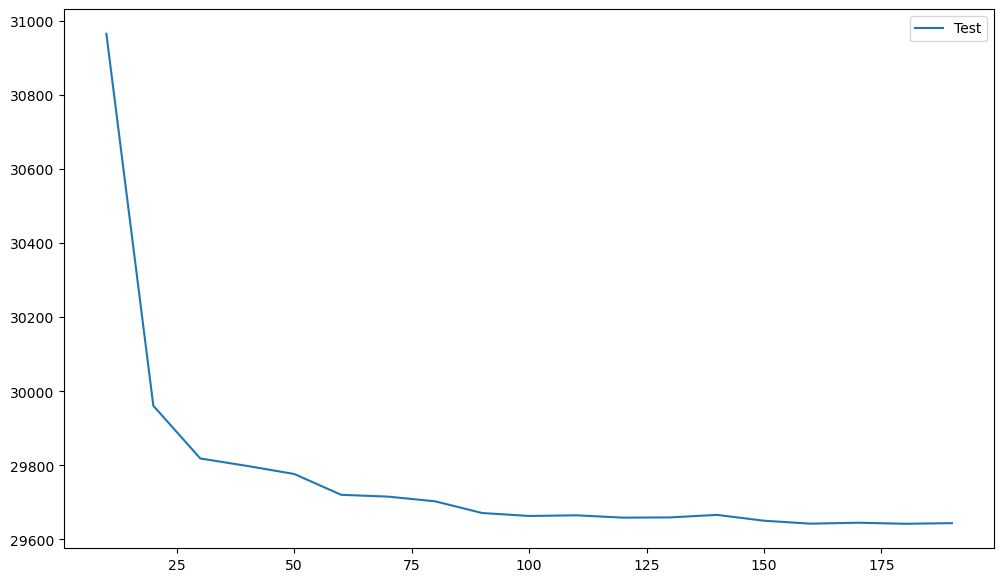

In [10]:
plt.figure(figsize=(12,7),dpi=100)
plt.plot(option,test, label='Test')
# plt.plot(option,train, label='Train')
plt.legend()
plt.show()

num_boost_round: range(100,200,10)

gamma: 75万左右有影响, 

lambda_:  (0-2,0.1)

mind_child_weight: [0,40,2]

booster: [gbtree, dart]

rate_drop: (0.1,1,0.1)

subsample: (0.1,1,0.1)

max_depth: (2,10,1)

colsample_bytree: (0.1,1,0.1)

colsample__bynode:(0.1,1,0.1)

In [16]:
option = np.arange(0.05,2.05,0.1)
len(option)

20

In [20]:
train = []
test = []
option = np.arange(2,10,1)
overfit = []

for i in option:
    params = {'max_depth': 5, 'seed':1210, "min_child_weight": i}
    result = xgb.cv(params, data_xgb, num_boost_round=100, nfold=5, seed=1210)
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])

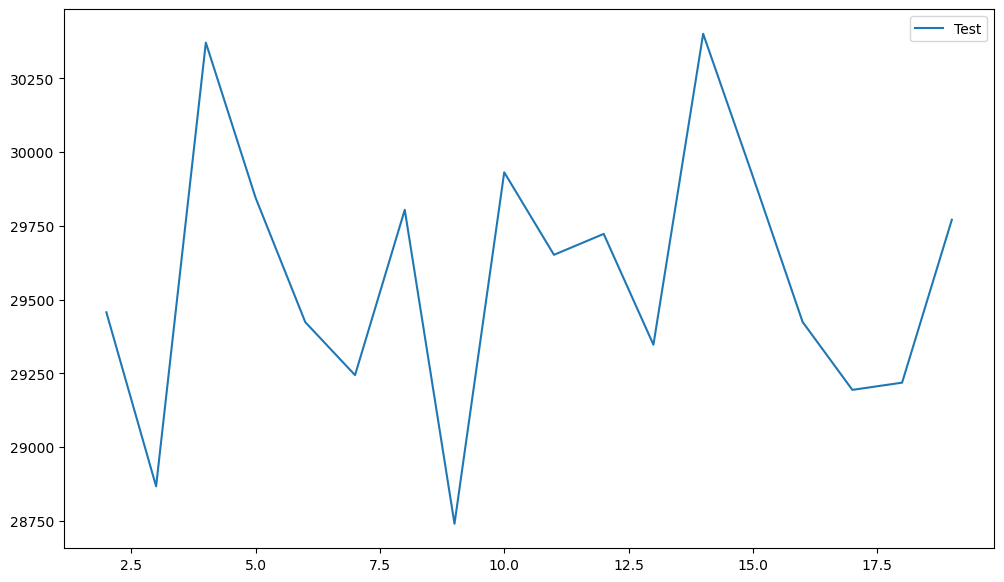

In [21]:
plt.figure(figsize=(12,7),dpi=100)
plt.plot(option,test, label='Test')
# plt.plot(option,train, label='Train')
plt.legend()
plt.show()

## 基于TEP对XGBoost进行超参数优化

In [23]:
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss
data = pd.read_csv('./data/train_encode.csv')
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
data_xgb = xgb.DMatrix(X, y)

### 定义目标函数

In [51]:
# 目标函数
def hyperopt_objective(params):
    paramsforxgb={
        'eta':params['eta'],
        'colsample_bytree':params['colsample_bytree'],
        'colsample_bynode':params['colsample_bynode'],
        'gamma':params['gamma'],
        'lambda':params['lambda'],
        'mind_child_weight':params['mind_child_weight'],
        'max_depth':params['max_depth'],
        'subsample':params['subsample'],
        'rate_drop':params['rate_drop'],
        'booster': 'dart',
        'verbosity':False,
        'seed':1412,
    }
    result = xgb.cv(paramsforxgb,data_xgb,metrics=('rmse'),
            num_boost_round = int(params['num_boost_round']),
                   )
    return result.iloc[-1,2]

### 参数空间

In [61]:
import warnings

# 忽略所有警告
warnings.filterwarnings('ignore')
params = {
    'num_boost_round': hp.quniform('num_boost_round',150,200,10),
    "eta":hp.quniform('eta',0.8,2.1,0.1),
    "colsample_bytree": hp.quniform('colsample_bytree',0.4,0.8,0.2),
    "colsample_bynode":hp.quniform('colsample_bynode', 0.4, 0.8,0.2),
    'gamma':hp.quniform('gamma',5e6,8e6,5e5),
    'lambda': hp.quniform('lambda',0.0,1.2,0.2),
    'mind_child_weight':hp.quniform('mind_child_weight',0,24,2),
    'subsample': hp.quniform('subsample',0.1,1.0,0.2),
    'rate_drop': hp.quniform('rate_drop',0.1,1.0,0.2),
    'max_depth':5,
         }

### 优化函数

In [62]:
def param_hyperopt(max_evals=100):
    trials = Trials()
    early_stop_fn = no_progress_loss(30)
    params_best = fmin(hyperopt_objective,
                      space=params,
                       algo=tpe.suggest,
                       max_evals=max_evals,
                       verbose=True,
                       trials=trials,
                       early_stop_fn=early_stop_fn,
                      )
    print(f"best_params: {params_best}")
    return params_best, trials

### 训练贝叶斯优化器

In [57]:
params_best, trials = param_hyperopt(100)

100%|████████████████████████████████████████████████████████████████████| 100/100 [22:36<00:00, 13.57s/trial, best loss: 26649.80958058425]


best_params: {'colsample_bynode': 1.0, 'colsample_bytree': 0.4, 'eta': 0.8, 'gamma': 5000000.0, 'lambda': 0.0, 
'max_deptj': 5, 'mind_child_weight': 4.0, 'num_boost_round': 200.0, 'rate_drop': 0.2, 'subsample': 1.0}

In [60]:
params_best, trials = param_hyperopt(200)

 30%|████████████████████▋                                               | 61/200 [15:37<35:37, 15.37s/trial, best loss: 27053.656185817526]


best_params: {'colsample_bynode': 0.6000000000000001, 'colsample_bytree': 0.4, 'eta': 1.2000000000000002, 'gamma': 
9500000.0, 'lambda': 1.0, 'mind_child_weight': 22.0, 'num_boost_round': 180.0, 'rate_drop': 0.2, 'subsample': 0.8}

In [63]:
params_best, trials = param_hyperopt(200)

 38%|██████████████████████████▏                                         | 77/200 [20:19<32:28, 15.84s/trial, best loss: 26967.181069050446]


best_params: {'colsample_bynode': 0.4, 'colsample_bytree': 0.6000000000000001, 'eta': 1.8, 'gamma': 6500000.0, 
'lambda': 0.4, 'mind_child_weight': 16.0, 'num_boost_round': 180.0, 'rate_drop': 0.2, 'subsample': 1.0}

    'booster': hp.choice('booster',['gbtree','dart'])
len(range(100,200,10)) * len(np.arange(0.85,2.1,0.2)) * len(np.arange(0.1,1.0,0.2)) * \
len(np.arange(0.1,1.0,0.2)) * len(np.arange(0.1,2.0,0.2)) * \
len(np.arange(0,40,2)) * len(list(range(2,11,1))) * len(np.arange(0.1,1.0,0.2)) * \
len(np.arange(0.1,1.0,0.1)) * 2  * len(np.arange(5e6,1.5e7,5e5)) 

In [47]:
params = {
    'num_boost_round': hp.quniform('num_boost_round',100,200,10),
    "eta":hp.quniform('eta',0.8,2.1,0.1),
    "colsample_bytree": hp.quniform('colsample_bytree',0.1,1.0,0.2),
    "colsample_bynode":hp.quniform('colsample_bynode', 0.1, 1.0,0.2),
    'gamma':hp.quniform('gamma',5e6,1.5e7,5e5),
    'lambda': hp.quniform('lambda',0.0,2.0,0.2),
    'mind_child_weight':hp.quniform('mind_child_weight',0,40,2),
    'max_depth': hp.choice('max_deptj',list(range(2,11,1))),
    'subsample': hp.quniform('subsample',0.1,1.0,0.2),
    'rate_drop': hp.quniform('rate_drop',0.1,1.0,0.2),
         }

for k,v in params.items():
    print(f"'{k}':params['{k}'],")

'num_boost_round':params['num_boost_round'],

'eta':params['eta'],

'colsample_bytree':params['colsample_bytree'],

'colsample_bynode':params['colsample_bynode'],

'gamma':params['gamma'],

'lambda':params['lambda'],

'mind_child_weight':params['mind_child_weight'],

'max_depth':params['max_depth'],

'subsample':params['subsample'],

'rate_drop':params['rate_drop'],